# Notebook to investigate how to build the "task change detector"

### Imports

In [196]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import math

# Imports DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset


# Imports from other modules and packages in the project
sys.path.append('../')

from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *

In [197]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [198]:
from pyaldata import *

In [199]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [200]:
dtype = torch.float32

In [201]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [202]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [203]:
data_path = '../Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [204]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

## Get train-val-test split

In [205]:
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(baseline_df, fold, target_variable= target_variable, no_outliers = False, force_data = True)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


In [206]:
xx_train_base.shape

(109, 100, 130)

#### Building the RNN model and Sequence Generator to predict X_t+1 from X_t

`Note` Now imported from sequence_datasets and models.py


In [207]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
#device = torch.device('cpu') 
dtype = torch.float32
path_to_models = './Models/Models_Task_Change'
if not os.path.exists(path_to_models):
    os.makedirs(path_to_models)
    print(f"Folder '{path_to_models}' created.")
# Set the seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)  # If using CUDA

num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

Folder './Models/Models_Task_Change' created.


In [208]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

lr = 0.00001
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 5
batch_size_train= 25
batch_size_val = 25

torch.manual_seed(42)

In [19]:
model = Task_Recog_Model(num_features, hidden_units, num_layers, num_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create an instance of SequenceDataset
train_dataset = SequenceDataset_TaskDetector(xx_train_base)  # Assuming you have X_train defined
val_dataset = SequenceDataset_TaskDetector(xx_val_base)  # Assuming you have X_train defined

loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in loader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader_val:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(loader_val)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}")

# Save the trained model
#torch.save(model.state_dict(), 'rnn_model.pth')

Epoch 1/100, Train Loss: 0.062407929450273514, Val Loss: 0.06650140229612589
Epoch 2/100, Train Loss: 0.025068063288927078, Val Loss: 0.03152813433014132


KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt

# Load test data and create DataLoader
test_dataset = SequenceDataset(xx_test_base)  # Assuming you have X_test defined
test_loader = data.DataLoader(test_dataset, batch_size=batch_size_train)

# Evaluate the model on the test data
model.eval()
test_loss = 0.0
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
        predictions.extend(outputs.tolist())
        ground_truth.extend(targets.tolist())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 0.0056816017330514595


In [18]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(ground_truth, predictions)
print(f"R-squared: {r2}")

R-squared: 0.994153882300603


In [19]:
# Convert predictions and ground truth to numpy arrays for visualization
predictions = np.array(predictions)
ground_truth = np.array(ground_truth)

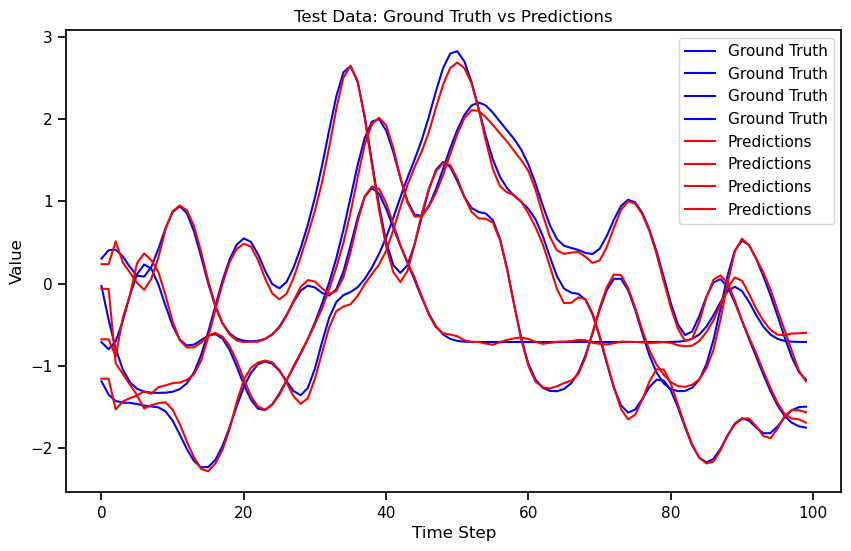

In [20]:
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(ground_truth[:100, 5:9], label='Ground Truth', color='blue')
plt.plot(predictions[:100, 5:9], label='Predictions', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Test Data: Ground Truth vs Predictions')
plt.legend()
plt.show()


### Test model on simulated data

In [209]:
sim_data_path = '../Data/Processed_Data/Simulated_50_'+name+'_'+date+'.pkl'

with open(sim_data_path, 'rb') as file:
    sim_data = pickle.load(file)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


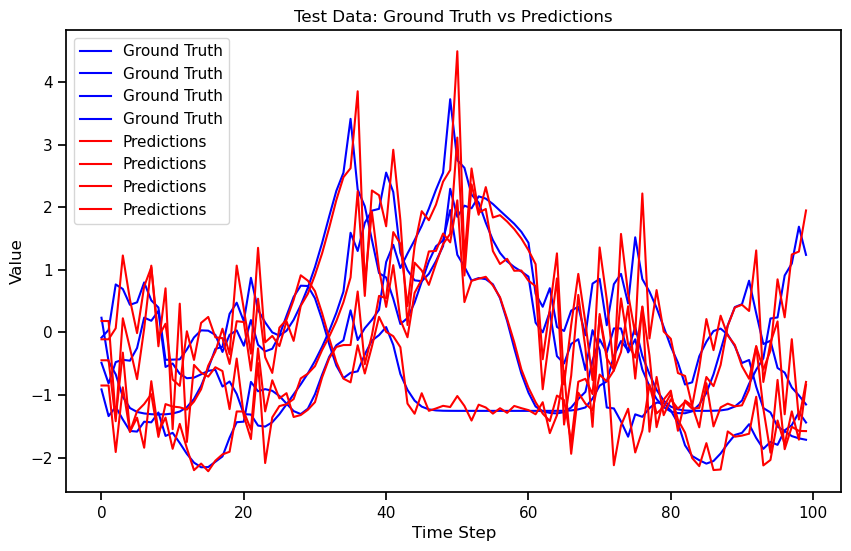

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Train trials 109
Test trials  

In [22]:
r2s = []

for i in range(0,50):

    baseline_df_sim = baseline_df.copy()
    baseline_df_sim['both_rates'] = sim_data['Set_'+str(i)].tolist()

    xx_train_sim, yy_train_sim, xx_val_sim, yy_val_sim,\
      xx_test_sim, yy_test_sim, info_train_sim, info_val_sim,\
          info_test_sim, list_mins_sim, \
            list_maxs_base= get_dataset(baseline_df_sim, fold, target_variable= target_variable, no_outliers = False, force_data = True)
    
    # Load test data and create DataLoader
    test_dataset = SequenceDataset(xx_test_sim[:,:,])  # Assuming you have X_test defined
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size_train)

    # Evaluate the model on the test data
    model.eval()
    test_loss = 0.0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.float()  # Convert input data to torch.float32
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            predictions.extend(outputs.tolist())
            ground_truth.extend(targets.tolist())

    test_loss /= len(test_loader)
    #print(f"Test Loss: {test_loss}")

    # Convert predictions and ground truth to numpy arrays for visualization
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    if i == 1:
        # Visualize the results
        plt.figure(figsize=(10, 6))
        plt.plot(ground_truth[:100, 5:9], label='Ground Truth', color='blue')
        plt.plot(predictions[:100, 5:9], label='Predictions', color='red')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title('Test Data: Ground Truth vs Predictions')
        plt.legend()
        plt.show()

    # Compute R-squared
    r2 = r2_score(ground_truth, predictions)
    #print(f"R-squared: {r2}")
    r2s.append(r2)




    

{'whiskers': [<matplotlib.lines.Line2D at 0x7f37ad160340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f37ad2b2490>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f37ad160490>],
 'medians': [<matplotlib.lines.Line2D at 0x7f37ad2b26a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f37ad2b28e0>],
 'means': []}

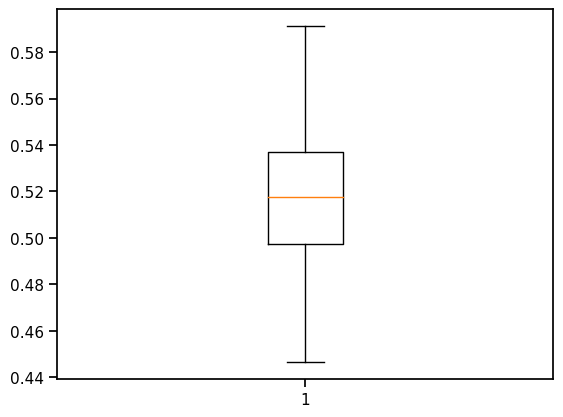

In [23]:
plt.boxplot(r2s)

None of the r2 for the simulated dataset is over 80%.

## Putting all together

#### The following part of the code should correspond to this logic/algorithm structure:

**Initialize with first task (~pretraining):**
- 1- Load Baseline Data and set task_id to 0, and max_id to 0 too
- 2- Train TaskDetectorRNN on Baseline Data
- 3- Compute R2 and define threshold
- 4- Create folder to save trained task detector models and save it with the name of the task (here 0)
- 5- Train hnet using task_id = 0.

**Continue with new data (could be the same task):**
- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

In [172]:
def reg_task_detector(model, alpha=1e-5, l1_ratio=0.5):
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: CausalTemporalLSTM instance
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    w_t = model.rnn.weight_ih_l0

    l1_loss = w_t.abs().sum() 
    l2_loss = w_t.pow(2.0).sum() 

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg 

In [173]:
def train_task_detector(model, criterion, optimizer, x_train, x_val):
    # Create an instance of SequenceDataset
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val = torch.tensor(x_val, dtype=torch.float32)
    
    train_dataset = SequenceDataset_TaskDetector(x_train)  # Assuming you have X_train defined
    val_dataset = SequenceDataset_TaskDetector(x_val)  # Assuming you have X_train defined

    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in loader_train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets) + reg_task_detector(model)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in loader_val:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        val_loss /= len(loader_val)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss}")

In [174]:
import os
import torch

def save_model(model, task_id, folder):
    # Define the directory path
    models_dir = "../Models"
    task_models_dir = os.path.join(models_dir, folder)

    # Check if the directory exists, if not, create it
    if not os.path.exists(task_models_dir):
        os.makedirs(task_models_dir)

    # Define the file name
    model_file_name = f"Model_Task_{task_id}.pth"  # Use .pth extension for PyTorch models

    # Save the model
    model_path = os.path.join(task_models_dir, model_file_name)

    # Save the model using torch.save
    torch.save(model, model_path)


In [189]:
def eval_model_taskrec(model, x_test, plot = False):
    # Evaluate and compute r2
    # Load test data and create DataLoader
    x_test = torch.tensor(x_test, dtype=torch.float32)
    test_dataset = SequenceDataset_TaskDetector(x_test)  # Assuming you have X_test defined
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size_train)

    # Evaluate the model on the test data
    model.eval()
    test_loss = 0.0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            predictions.extend(outputs.tolist())
            ground_truth.extend(targets.tolist())

    # Compute R-squared
    r2 = r2_score(ground_truth, predictions)
    print(f"R-squared: {r2}")

    if plot:
        # Convert predictions and ground truth to numpy arrays for visualization
        predictions = np.array(predictions)
        ground_truth = np.array(ground_truth)
        # Visualize the results
        plt.figure(figsize=(10, 6))
        plt.plot(ground_truth[:100, 6], label='Ground Truth', color='blue')
        plt.plot(predictions[:100, 6], label='Predictions', color='red')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title('Test Data: Ground Truth vs Predictions')
        plt.legend()
        plt.show()

        

    return r2

### 1) Initialize using Task 0

In [224]:
""" Initialize: Using task 0 """

# Loading data
data_task_0 = baseline_df
xx_train_base, yy_train_base, xx_val_base, yy_val_base,\
      xx_test_base, yy_test_base, info_train_base, info_val_base,\
          info_test_base, list_mins_base, \
            list_maxs_base= get_dataset(data_task_0, fold, target_variable= target_variable, no_outliers = False, force_data = True)
task_id = 0
max_id = 0

# Training task detector on task 0
model = Task_Recog_Model(num_features, hidden_units, num_layers, num_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train model on first task
train_task_detector(model, criterion, optimizer, xx_train_base, xx_val_base)

# Save the trained model
save_model(model, task_id, "Models_Task_Recognition")

# Evaluate the model and set a threshold
r2_task = eval_model_taskrec(model, xx_test_base)
thrs = 0.7 * r2_task
print('The threshold for the taks detection algorith is: ', thrs)

# Train hypernetwork on task 0 

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0


/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 1/10, Train Loss: 0.9080686569213867, Val Loss: 0.7993683533536063
Epoch 2/10, Train Loss: 0.7142548561096191, Val Loss: 0.7205163588126501
Epoch 3/10, Train Loss: 0.6609395146369934, Val Loss: 0.6825184060467614
Epoch 4/10, Train Loss: 0.6370420455932617, Val Loss: 0.6604023785502823
Epoch 5/10, Train Loss: 0.6602571606636047, Val Loss: 0.6473598496781455
Epoch 6/10, Train Loss: 0.6043257117271423, Val Loss: 0.640091989879255
Epoch 7/10, Train Loss: 0.632373034954071, Val Loss: 0.6360231461348357
Epoch 8/10, Train Loss: 0.5812190175056458, Val Loss: 0.6333962033192316
Epoch 9/10, Train Loss: 0.6226615905761719, Val Loss: 0.6316368811660342
Epoch 10/10, Train Loss: 0.6669850945472717, Val Loss: 0.6304736932118734
R-squared: 0.3555735766920459
The threshold for the taks detection algorith is:  0.24890150368443212


/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


##### Defining hyperparameters

In [34]:
num_dim_output = yy_train_base.shape[2]
num_features = xx_train_base.shape[2]

# Hyperparameters LSTM class (from force model without hnet)
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1e-5
l1_ratio_reg = 0.5

loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
n_hidden_units = 300
num_layers = 1
input_size = 49
dropout = 0.2

#Other training hyperparameters

lr_gamma= 1.37 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 19
batch_size_train= 25
batch_size_val = 25

lr = 0.001
beta = 1e-1


torch.manual_seed(42)

In [35]:
from hypnettorch.hnets import HyperNetInterface
from hypnettorch.hnets import HMLP

#### Defining the template, main and hnet models and initializing them

In [36]:
template_m = Causal_Simple_RNN(num_features=num_features, 
                    hidden_units= n_hidden_units, 
                    num_layers = num_layers, 
                    out_dims = num_dim_output, ).to(device)

param_shapes = [p.shape for p in list(template_m.parameters())]

num_conditions = 60 # we want more possible conditions than what we can reach
size_task_embedding = 8 #to check if the best one

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[13], 
            num_cond_embs=num_conditions).to(device)

for param in hnet.parameters():
    param.requires_grad = True

w_test = hnet(cond_id = 0)

LSTM_ = False

model = RNN_Main_Model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers,out_dims=num_dim_output,  
                            dropout= dropout,  LSTM_ = LSTM_).to(device)

for param in model.parameters():
    param.requires_grad = False

    
#### Apply initialization to the hnet following the recommendations of hypnettorch
hnet.apply_hyperfan_init()

Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).


#### Training the hnet for the 1st task

In [40]:
print('Task id: ', task_id)

calc_reg = False 

if task_id >0:
    calc_reg = True

# Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=lr_step_size, 
                                gamma=lr_gamma)

train_losses_, val_losses_, best_w_ =train_current_task(
        model, 
        hnet,
        yy_train_base, 
        xx_train_base,
        yy_val_base,
        xx_val_base,
        optimizer,
        scheduler,
        calc_reg = calc_reg,
        cond_id = task_id,
        lr=lr,
        lr_step_size=5,
        lr_gamma= lr_gamma, #0.9
        sequence_length_LSTM = seq_length_LSTM, #15
        batch_size_train = batch_size_train, #15
        batch_size_val = batch_size_train, #15
        num_epochs=1000, 
        delta = 8,
        beta = beta,             
        regularizer=reg_hnet,
        l1_ratio = l1_ratio_reg, #0.5
        alpha = alpha_reg,    
        early_stop = 5,
        chunks = False)
    
# Save the trained model
save_model(hnet, task_id, "HNET_Task_Recog")


Task id:  0
Epoch 000 Train 0.4527 Val 1.6738
Epoch 001 Train 0.4489 Val 1.7358
Epoch 002 Train 0.4419 Val 1.6670
Epoch 003 Train 0.4380 Val 1.6833
Epoch 004 Train 0.4324 Val 1.6747
Epoch 005 Train 0.4308 Val 1.6819
Epoch 006 Train 0.4268 Val 1.7244
Epoch 007 Train 0.4221 Val 1.6607
Epoch 008 Train 0.4158 Val 1.6798
Epoch 009 Train 0.4115 Val 1.7366
Epoch 010 Train 0.4284 Val 1.7763
Epoch 011 Train 0.4180 Val 1.7206
Epoch 012 Train 0.4124 Val 1.6466
Epoch 013 Train 0.4097 Val 1.7314
Epoch 014 Train 0.4040 Val 1.6571
Epoch 015 Train 0.3976 Val 1.6466
Epoch 016 Train 0.3937 Val 1.7615
Decrease LR
Epoch 017 Train 0.3926 Val 1.6568
Epoch 018 Train 0.3622 Val 1.6651
Epoch 019 Train 0.3553 Val 1.6369
Epoch 020 Train 0.3617 Val 1.6503
Epoch 021 Train 0.3598 Val 1.6861
Epoch 022 Train 0.3558 Val 1.6506
Epoch 023 Train 0.3530 Val 1.6594
Decrease LR


### 1) Loop over any new task

#### 1.1 - Start only using one extra task and see if it works

- 6- Load new data
- 7- For each of the previous tasks test the trained TaskDetectorRNN and compute the R2 score. Save in a list all R2 scores.
    - if max(r2_list) > thrs: get argmax of the list as the task_id
        - use h_net with the task_id corresponding to the data.
        - report results (R2,...)
    - else:
        - max_id += 1
        - task_id = max_id
        - train TaskDetectorRNN on new data and save it with its task_id
        - check R2 > threshold --> else report ERROR.
        - train h_net using this task_id.
        - report results (R2,...)

In [219]:
num_layers = 1
hidden_units = 10

In [220]:
task_id

1

In [221]:
import copy

# I feel there is something wrong with the models or the way of training, check it an build a real trainer

In [222]:
# Loading data

task_id = 0
max_id = 0
test_sim_set = 5
baseline_df_sim = baseline_df.copy()
baseline_df_sim['both_rates'] = sim_data['Set_'+str(test_sim_set)].tolist()
new_data = baseline_df_sim
x_train, y_train, x_val, y_val,\
      x_test, y_test, info_train, info_val,\
          info_test, list_mins_base, \
            list_maxs_base= get_dataset(new_data, fold, target_variable= target_variable, no_outliers = False, force_data = True)

path_recog_models = '../Models/Models_Task_Recognition'


r2_list = []
for i,m in enumerate(os.listdir(path_recog_models)):
    print(m)
    model_i = torch.load(os.path.join(path_recog_models, m))
    dtype = torch.float32
    r2_i = eval_model_taskrec(model_i, x_test)
    r2_list.append(r2_i)

max_r2 = max(r2_list)

if max_r2 > thrs:
    task_id = np.arg_max(r2_list)
else:
    print('This data comes from a different task !')
    max_id += 1
    task_id = max_id
    model_new_task = copy.deepcopy(model_i)
    #Task_Recog_Model(num_features, hidden_units, num_layers, num_features)
    criterion = huber_loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #Train model on first task
    train_task_detector(model_new_task, criterion, optimizer, x_train, x_val)

    # Save the trained model
    save_model(model_new_task, task_id, "Models_Task_Recognition")

    # Evaluate the model and set a threshold
    r2_task = eval_model_taskrec(model_new_task, x_test)
    
# thrs = 0.7 * r2_task
# print('The threshold for the taks detection algorith is: ', thrs)

Train trials 109
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Model_Task_1.pth
R-squared: 0.6911715268040544
Model_Task_0.pth


/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


R-squared: 0.6911715268040544
This data comes from a different task !


/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


Epoch 1/10, Train Loss: 0.03889808803796768, Val Loss: 0.03339621816175403
Epoch 2/10, Train Loss: 0.03614895045757294, Val Loss: 0.03339621814450732
Epoch 3/10, Train Loss: 0.045152727514505386, Val Loss: 0.033396218403208035
Epoch 4/10, Train Loss: 0.04217546805739403, Val Loss: 0.03339621821349418
Epoch 5/10, Train Loss: 0.027001678943634033, Val Loss: 0.033396218015156964
Epoch 6/10, Train Loss: 0.035603441298007965, Val Loss: 0.033396218006533605
Epoch 7/10, Train Loss: 0.04012949392199516, Val Loss: 0.033396218041027034
Epoch 8/10, Train Loss: 0.044220950454473495, Val Loss: 0.033396217980663535
Epoch 9/10, Train Loss: 0.03531035780906677, Val Loss: 0.033396218368714606


KeyboardInterrupt: 

/home/nerea/CL_UpperLimb_Control/Notebooks/../src/sequence_datasets.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)


R-squared: 0.6911715268040544


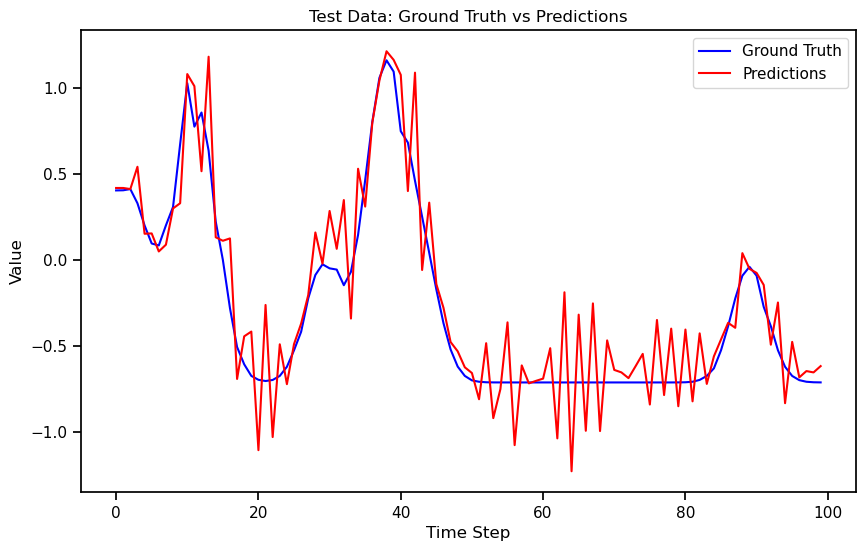

In [ ]:
# Evaluate the model and set a threshold
r2_task = eval_model_taskrec(model_new_task, x_test, plot = True)